# Predict Tags on StackOverflow with Linear Models

In this assignment you will learn how to predict tags for posts from [StackOverflow](https://stackoverflow.com). To solve this task you will use multilabel classification approach.

### Libraries

In this task you will need the following libraries:
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.

### Text preprocessing
For this and most of the following assignments you will need to use a list of stop words. It can be downloaded from *nltk*

In this task you will deal with a dataset of post titles from StackOverflow. You are provided a split to 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available).

In [1]:
from ast import literal_eval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
train      = pd.read_csv('data/train.tsv', sep='\t')
validation = pd.read_csv('data/validation.tsv', sep='\t')
test       = pd.read_csv('data/test.tsv', sep='\t')

In [3]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,['r']
1,mysql select all records where a datetime fiel...,"['php', 'mysql']"
2,How to terminate windows phone 8.1 app,['c#']
3,get current time in a specific country via jquery,"['javascript', 'jquery']"
4,Configuring Tomcat to Use SSL,['java']


As you can see, *title* column contains titles of the posts and *tags* column contains the tags. It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [4]:
X_train, y_train = train['title'].values, train['tags'].values            # Splits train dataset to features set (X_train) and target set (y_train)
X_val, y_val     = validation['title'].values, validation['tags'].values  # Splits validation dataset to features set and target set
X_test           = test['title'].values                                   # Creates an array of features for test set (X_test)

print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_val shape:',X_val.shape)
print('y_val shape:',y_val.shape)
print('X_test shape:',X_test.shape)

X_train shape: (100000,)
y_train shape: (100000,)
X_val shape: (30000,)
y_val shape: (30000,)
X_test shape: (20000,)


One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5?*, *"Flip*, etc. To prevent the problems, it's usually useful to prepare the data somehow. In this task you'll write a function, which will be also used in the other assignments. 

**Task 1 (TextPrepare).** Implement the function *text_prepare* following the instructions. After that, run the function *test_test_prepare* to test it on tiny cases and submit it to Coursera.

In [5]:
import nltk                           # Natural Language Toolkit. Library to work with NLP
nltk.download('stopwords')            # Download a file with stopwords within
from nltk.corpus import stopwords
import re                             # Regular Expressions Library

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/looqbox/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
replace_by_space = re.compile('[/(){}\[\]\|@,;]')            
bad_symbols      = re.compile('[^0-9a-z #+_]')               
stopwords        = set(stopwords.words('english'))

# Creates a function to normalize the texts.
def text_prepare(text):
    text = text.lower() # lowercase text
    text = replace_by_space.sub(' ',text)                    # replace replace_by_space symbols by space in text
    text = bad_symbols.sub('',text)                          # delete symbols which are in bad_symbols from text
    text = text.split(' ')                                   # splits a text into a list of words
    text = [word for word in text if word not in stopwords]  # delete stopwords from text
    if '' in text: text.remove('')                           # remove a empty string inside a list
    text = ' '.join(text)                                    # concatenate by space a list of words into a string 
    return text

In [7]:
text = "SQL Server - any equivalent of Excel's CHOOSE function?"

In [8]:
text = text_prepare(text)

In [9]:
text

'sql server equivalent excels choose function'

In [10]:
# Function to test text_prepare()
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
               "How to free c++ memory vector<int> * arr?"]
    answers  = ["sql server equivalent excels choose function",
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
        return "Basic tests are passed."

In [11]:
print(test_text_prepare())

Basic tests are passed.


In [12]:
# Import questions to an array
prepared_questions = []
for line in open("data/text_prepare_tests.tsv", encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [13]:
X_train[:5]

array(['How to draw a stacked dotplot in R?',
       'mysql select all records where a datetime field is less than a specified value',
       'How to terminate windows phone 8.1 app',
       'get current time in a specific country via jquery',
       'Configuring Tomcat to Use SSL'], dtype=object)

In [14]:
# Runs the text_prepare function to normalize each question in X_train, X_val, X_test

X_train = [text_prepare(x) for x in X_train]
X_val   = [text_prepare(x) for x in X_val]
X_test  = [text_prepare(x) for x in X_test]

In [15]:
X_train[:5]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app',
 'get current time specific country via jquery',
 'configuring tomcat use ssl']

---

For each tag and for each word calculate how many times they occur in the train corpus. 

**Task 2 (WordsTagsCount).** Find 3 most popular tags and 3 most popular words in the train data and show the results.

In [16]:
# Collections implements high-performance container datatypes (beyond the built-in types list, dict and tuple) 
# and contains many useful data structures that you can use to store information in memory.
import collections

replace_special_chars = re.compile('\'|\`|\~|\!|\@|\#|\$|\%|\^|\&|\*|\(|\)|\+|\=|\[|\{|\]|\}|\||\\|\'|\<|\.|\>|\?|\/|\""|\;|\:|\s')

# Dictionary of all tags from train corpus with their counts.
tags_count = {}
# Dictionary of all words from train corpus with their counts.
words_count = {}

# Dictionary with counts for each tag
for line in train['tags'].values:
    line = replace_special_chars.sub('',line).split(',')
    for tag in line:
        if tag not in tags_count:
            tags_count[tag] = 1
        else:
            tags_count[tag] += 1

tags_count.pop('', None)
            
# Dictionary with counts for each word (nomalized texts)
for line in train['title'].values:
    line = text_prepare(line).split(' ')
    for word in line:
        if word not in words_count:
            words_count[word] = 1
        else:
            words_count[word] += 1
            
words_count.pop('', None)

16471

In [17]:
# Creates dictionary for most common tags and most common words. We can find below top three tags and words
most_common_tags  = sorted(tags_count.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_count.items(), key=lambda x: x[1], reverse=True)[:3]

In [18]:
# Most 3 popular tags
print("Most 3 popular tags:")
print(most_common_tags)

print('-'*54)

# Most 3 popular words
print("Most 3 popular words:")
print(most_common_words)

Most 3 popular tags:
[('c', 28665), ('javascript', 19078), ('java', 18661)]
------------------------------------------------------
Most 3 popular words:
[('using', 8278), ('php', 5614), ('java', 5501)]


### Transforming text to a vector

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. You can find below two of them.

#### 1. Bag of words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And iterate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   
Implementing the described encoding in the function *bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data. You can test your code using the function *test_bag_of_words*.

In [19]:
# Converting Text to Vector
dict_size    = 5000

# Creates a dictionary with a index for each word
words_to_index = {j[0]:i for i, j in enumerate(sorted(words_count.items(), key = lambda x: x[1], reverse = True)[:dict_size])}
# Creates a dictionary with a word for each index. Looks like the above dictionary, but inverted
index_to_words = {i:j[0] for i, j in enumerate(sorted(words_count.items(), key = lambda x: x[1], reverse = True)[:dict_size])}
# Creates an array with each word
allWords       = words_to_index.keys()

def bag_of_words(text, words_to_index, dict_size):
    result_vector       = np.zeros(dict_size) # n-array filled with zeros
    keys                = [words_to_index[i] for i in text.split(' ') if i in words_to_index.keys()] # Gets the index for each word found in dictionary
    result_vector[keys] = 1 # Each slot receive 1 for each index in keys
    return result_vector

In [20]:
# Function to test bag_of_words()
def test_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples       = ['hi how are you']
    answers        = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [21]:
test_bag_of_words()

'Basic tests are passed.'

Now apply the implemented function to all samples (this might take up to a minute):

In [22]:
from scipy import sparse as sp_sparse

In [23]:
X_train_bag = sp_sparse.vstack([sp_sparse.csr_matrix(bag_of_words(text, words_to_index, dict_size)) for text in X_train])
X_val_bag   = sp_sparse.vstack([sp_sparse.csr_matrix(bag_of_words(text, words_to_index, dict_size)) for text in X_val])
X_test_bag  = sp_sparse.vstack([sp_sparse.csr_matrix(bag_of_words(text, words_to_index, dict_size)) for text in X_test])
print('X_train shape ', X_train_bag.shape)
print('X_val shape ', X_val_bag.shape)
print('X_test shape ', X_test_bag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


As you might notice, we transform the data to sparse representation, to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however sklearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

**OBS.: sp_sparse.vstack - Stack sparse matrices vertically (row wise)**

**Task 3 (BagOfWords).** For the 11th row in *X_train_bag* find how many non-zero elements it has.

In [24]:
row                     = X_train_bag[10].toarray()[0]
non_zero_elements_count = np.count_nonzero(row)
print(non_zero_elements_count)

7


---

#### 2. TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Implement function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Use *train* corpus to train a vectorizer. Don't forget to take a look into the arguments that you can pass to it. We suggest that you filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in your vocabulary. 

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
print(X_train[:3])

['draw stacked dotplot r', 'mysql select records datetime field less specified value', 'terminate windows phone 81 app']


In [26]:
# Creates a function to convert a collection of raw documents to a matrix of TF-IDF features.
def tfidf_features(X_train, X_val, X_test):
    tfidf_vectorizer = TfidfVectorizer(
                         #input         = 'content', 
                         #encoding      = 'utf-8', 
                         #decode_error  = 'strict', 
                         #strip_accents = None, 
                         #lowercase     = True, 
                         #preprocessor  = None, 
                         #tokenizer     = None, 
                         #analyzer      = 'word', 
                         #stop_words    = None, 
                         token_pattern  = '(\S+)', # Means any no white space
                         ngram_range    = (1, 2), 
                         max_df         = .9, 
                         min_df         = 5, 
                         #max_features  = None, 
                         #vocabulary    = None, 
                         #binary        = False, 
                         #dtype         = <class 'numpy.int64'>, 
                         norm           = None, 
                         #use_idf       = True, 
                         smooth_idf     = False, 
                         sublinear_tf   = False
    )
    
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val   = tfidf_vectorizer.transform(X_val)
    X_test  = tfidf_vectorizer.transform(X_test)
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

In [27]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [28]:
tfidf_vocab['c++']

1976

In [29]:
tfidf_reversed_vocab[1976]

'c++'

---

### MultiLabel Classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [30]:
from sklearn.preprocessing import MultiLabelBinarizer

In [31]:
y_train[0:4]

array(["['r']", "['php', 'mysql']", "['c#']", "['javascript', 'jquery']"],
      dtype=object)

Each tag has some special characteres like **brackets []**, **quotes ' '** and **commas ,** . So, we need to remove them and then create an array of tags to the MultiLabel Classifier

In [32]:
# Removes special characteres in tags' arrays
y_train = [replace_special_chars.sub('',x).split(',') for x in y_train]
y_val   = [replace_special_chars.sub('',x).split(',') for x in y_val]

# Creates the Multilabel Classifier and then fit it with the tags
mlb     = MultiLabelBinarizer(classes = sorted(tags_count.keys()))
y_train = mlb.fit_transform(y_train)
y_val   = mlb.fit_transform(y_val)

Implement the function *train_classifier* for training a classifier. In this task we suggest to use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [33]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition.nmf import NMF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

In [34]:
def train_classifier(X_train, y_train, C=1.0, penalty='l2'):
    lr = LogisticRegression(solver = 'newton-cg',  # Algorithm to use in the optimization problem.
                            penalty = penalty,     # Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.
                            n_jobs = -1            # Number of CPU cores used when parallelizing over classes if multi_class=’ovr’”. If given a value of -1, all cores are used.
    )
    model = OneVsRestClassifier(lr).fit(X_train,y_train)
    return model

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [35]:
classifier_bag   = train_classifier(X_train_bag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [36]:
y_val_predicted_labels_bag = classifier_bag.predict(X_val_bag)
y_val_predicted_scores_bag = classifier_bag.decision_function(X_val_bag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [37]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed      = mlb.inverse_transform(y_val)
for i in range(3):
    print("Title: {}\nTrue Labels: {}\nPredicted Labels: {}\n".format(
    X_val[i],
    ','.join(y_val_inversed[i]),
    ','.join(y_val_pred_inversed[i])
    ))

Title: odbc_exec always fail
True Labels: php,sql
Predicted Labels: 

Title: access base classes variable within child class
True Labels: javascript
Predicted Labels: c

Title: contenttype application json required rails
True Labels: ruby,ruby-on-rails
Predicted Labels: rest,ruby-on-rails



Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

---

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

Implement the function *printEvaluationScores* which calculates and prints to stdout:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*

In [39]:
def print_evaluation_scores(y_val, predicted):
    print("Accuracy: {}".format(accuracy_score(y_val, predicted)))
    print("F1-Score Macro: {}".format(f1_score(y_val, predicted, average='macro')))
    print("F1-Score Micro: {}".format(f1_score(y_val, predicted, average='micro')))
    print("F1-Score Weighted: {}".format(f1_score(y_val, predicted, average='weighted')))
    print("Average Precision Macro: {}".format(average_precision_score(y_val, predicted, average='macro')))
    print("Average Precision Micro: {}".format(average_precision_score(y_val, predicted, average='micro')))
    print("Average Precision Weighted: {}".format(average_precision_score(y_val, predicted, average='weighted')))

In [40]:
print('Bag of Words')
print_evaluation_scores(y_val, y_val_predicted_labels_bag)
print("\n")
print('Tf-Idf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag of Words
Accuracy: 0.37903333333333333
F1-Score Macro: 0.5056134513607173
F1-Score Micro: 0.6850858313853504
F1-Score Weighted: 0.6612901542649714
Average Precision Macro: 0.3464048383393147
Average Precision Micro: 0.4973779306428934
Average Precision Weighted: 0.5300176748368732


Tf-Idf
Accuracy: 0.2912
F1-Score Macro: 0.4678527817679227
F1-Score Micro: 0.6265752027975781
F1-Score Weighted: 0.6232139567578707
Average Precision Macro: 0.27633106954206804
Average Precision Micro: 0.40119578425061925
Average Precision Weighted: 0.4601333466695317


You might also want to plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Provided function *roc_auc* can make it for you. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes

In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
%matplotlib inline

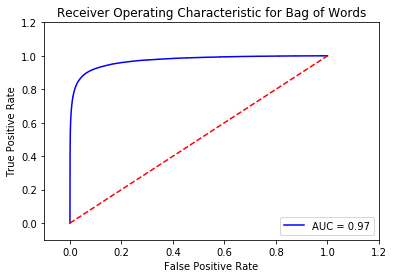

In [42]:
# ROC curve for Bag of Words
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val.ravel(), y_val_predicted_scores_bag.ravel())
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic for Bag of Words')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

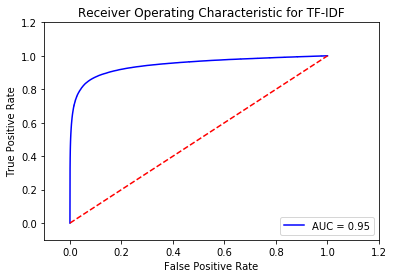

In [43]:
# ROC curve for TF-IDF
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val.ravel(), y_val_predicted_scores_tfidf.ravel())
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic for TF-IDF')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

---

### Analysis of the most important features

Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weigths in your logistic regression model.

Function *print_words_for_tag* to find them. Get back to sklearn documentation on [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) and [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if needed.

In [44]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    print('Tag: {}'.format(tag))
    est = classifier.estimators_[tags_classes.index(tag)]
    top_positive_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][-5:]]  # top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[index] for index in est.coef_.argsort().tolist()[0][:5]] # bottom-5 words  sorted by the coefficients.
    print('Top positive words: {}'.format(', '.join(top_positive_words)))
    print('Top negative words: {}\n'.format(', '.join(top_negative_words)))

In [45]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, allWords)
print_words_for_tag(classifier_tfidf, 'python', mlb.classes, tfidf_reversed_vocab, allWords)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, allWords)

Tag: c
Top positive words: nhibernate, unity, compilers, c++, c#
Top negative words: php, java, afnetworking, python, swift

Tag: python
Top positive words: flask, tkinter, numpy, pandas, python
Top negative words: php, unable import, c#, java, python pil

Tag: linux
Top positive words: value c, creating new, reaching, calling php, linux
Top negative words: displaying, aspnet, codeigniter, echo, nokogiri

